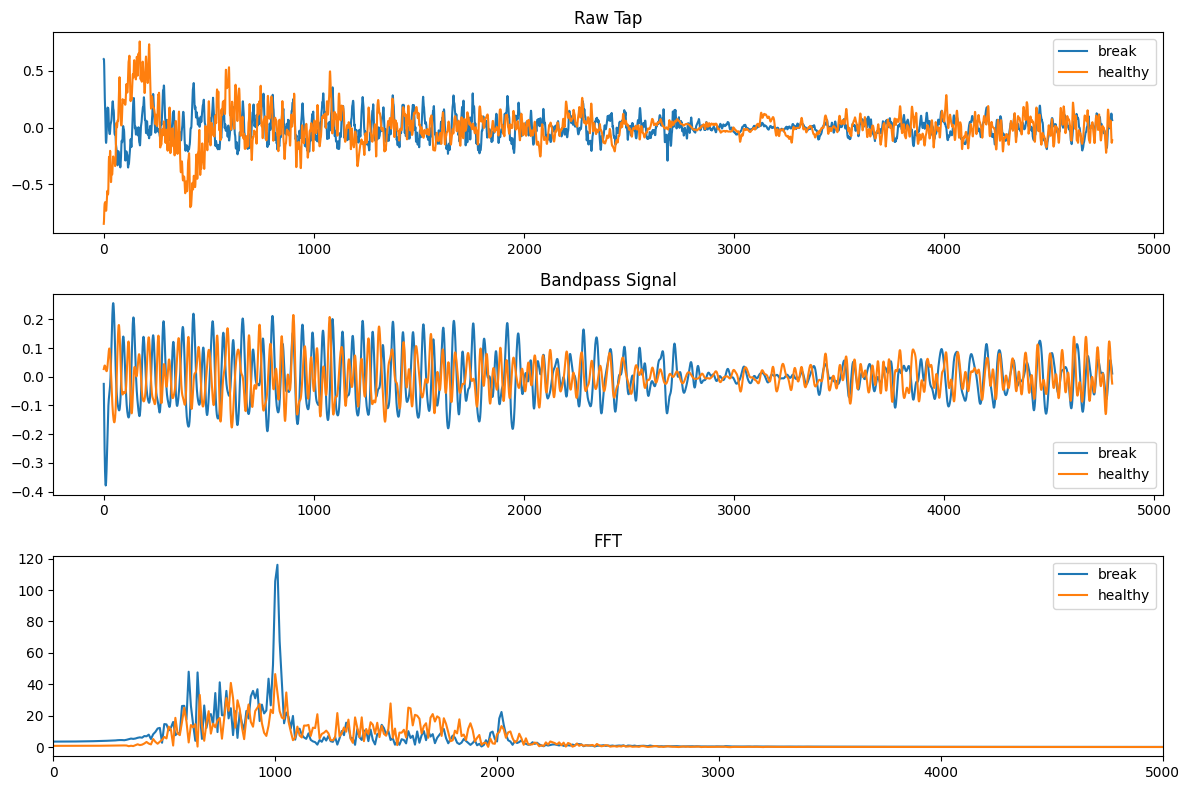

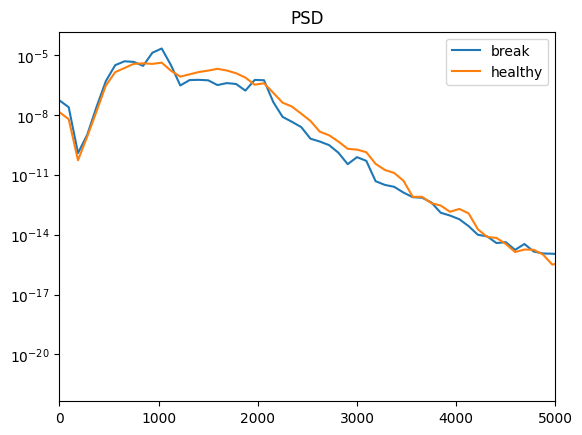


TEST:
Energy: 6.048413806781403e-05
Centroid: 966.8609743801377
HighFreq: 6.333478572995974e-07
Flatness: 1.8149064701087223e-05

HEALTHY:
Energy: 3.387717813017972e-05
Centroid: 1120.8583297324853
HighFreq: 6.249229178702791e-07
Flatness: 3.5078115944095374e-05
CRACK DETECTED


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import butter, filtfilt, welch, find_peaks

# ================= USER FILES =================
FILE = "data_record_phone/break/break3.wav"      # test file
HEALTHY = "data_record_phone/healthy/healthy_c1.wav"     # reference

# ================= PARAMETERS =================
LOW = 500
HIGH = 2000
WINDOW_MS = 100

# =============================================

def bandpass(x, fs, low, high, order=4):
    b,a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b,a,x)

def extract_features(sig, fs):

    # FFT
    fft = np.abs(np.fft.rfft(sig))
    freq = np.fft.rfftfreq(len(sig), 1/fs)

    # PSD
    f,P = welch(sig, fs, nperseg=512)

    energy = np.sum(P)
    centroid = np.sum(f*P)/np.sum(P)
    hf = np.sum(P[f>2000])
    flat = np.exp(np.mean(np.log(P+1e-12))) / np.mean(P)

    return energy, centroid, hf, flat, freq, fft, f, P

def process(file):

    fs, d = wavfile.read(file)

    if d.ndim>1:
        d=d[:,0]

    d = d.astype(np.float32)
    d /= np.max(np.abs(d))

    # find tap
    peaks,_ = find_peaks(np.abs(d), height=0.4, distance=fs)

    p = peaks[0]

    W = int(WINDOW_MS*fs/1000)

    seg = d[p:p+W]

    # bandpass
    filt = bandpass(seg, fs, LOW, HIGH)

    feats = extract_features(filt, fs)

    return fs, seg, filt, feats


# ================= RUN =================

fs, raw, filt, feats = process(FILE)
fs2, raw_h, filt_h, feats_h = process(HEALTHY)

E, C, HF, F, freq, fft, f, P = feats
Eh, Ch, HFh, Fh, freq_h,fft_h, fh, Ph = feats_h

# ================= PLOTS =================

plt.figure(figsize=(12,8))

plt.subplot(311)
plt.plot(raw)
plt.plot(raw_h)
plt.title("Raw Tap")
plt.legend(["break","healthy"])


plt.subplot(312)
plt.plot(filt)
plt.plot(filt_h)
plt.title("Bandpass Signal")
plt.legend(["break","healthy"])


plt.subplot(313)
plt.plot(freq, fft)
plt.plot(freq_h, fft_h)
plt.xlim(0,5000)
plt.title("FFT")
plt.legend(["break","healthy"])


plt.tight_layout()
plt.show()

plt.figure()
plt.semilogy(f,P)
plt.semilogy(fh,Ph)
plt.xlim(0,5000)
plt.title("PSD")
plt.legend(["break","healthy"])
plt.show()


# ================= FEATURES =================

print("\nTEST:")
print("Energy:",E)
print("Centroid:",C)
print("HighFreq:",HF)
print("Flatness:",F)

print("\nHEALTHY:")
print("Energy:",Eh)
print("Centroid:",Ch)
print("HighFreq:",HFh)
print("Flatness:",Fh)

# ================= DECISION =================

if (HF > HFh*1.1 and F > Fh*1.05) or (C < Ch*0.9):
    print("CRACK DETECTED")
else:
    print("DISPLAY OK")
